In [10]:
# %%
import torch
import yaml
from argparse import Namespace
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from model import get_model_and_optim
from data import prepare_nuclear_data
import seaborn as sns
sns.set()

# Download required files from Zenodo
wget -nc https://zenodo.org/record/8403220/files/nuclr_files.tar

tar -xvf nuclr_files.tar

rm nuclr_files.tar

Now you should have three folders: `checkpoints/`, `data/` and `plots`. 

In [3]:
# !wget -nc https://zenodo.org/record/8403220/files/nuclr_files.tar
# !tar -xvf nuclr_files.tar
# !rm nuclr_files.tar

# Load data and model

In [4]:
# load args from disk
with open("checkpoints/args.yaml", "r") as f:
    args = yaml.load(f, Loader=yaml.FullLoader)
args = Namespace(**args)
print("Loaded args:", args, "\n")

data = prepare_nuclear_data(args)
print("Loaded Data:", data._fields, "\n")

model, _ = get_model_and_optim(data, args)
model.load_state_dict(torch.load("checkpoints/fig1_model_16.pt"))


Loaded args: Namespace(BATCH_SIZE=1024, CKPT_FREQ=10, CLIP_GRAD=0.001, DEPTH=2, DEV='cuda:1', EPOCHS=50000, HIDDEN_DIM=2048, HOLDOUT='false', LIPSCHITZ='false', LOG_FREQ=1, LR=0.0001, MODEL='baseline', READOUT='identity', ROOT='/work/submit/kitouni/ai-nuclear', SCHED='cosine', SEED=0, SIGMOID_READOUT='false', START_FROM='none', TARGETS_CLASSIFICATION={}, TARGETS_REGRESSION={'binding_semf': 1.0, 'n': 1.0, 'qa': 1.0, 'qbm': 1.0, 'qbm_n': 1.0, 'qec': 1.0, 'radius': 1.0, 'sn': 1.0, 'sp': 1.0, 'z': 1.0}, TMS='remove', TRAIN_FRAC=0.9, WANDB=False, WD=0.01, basedir='/work/submit/kitouni/ai-nuclear/FULL/model_baseline/wd_0.01/lr_0.0001/epochs_50000/trainfrac_0.9/hiddendim_2048/depth_2/seed_0/batchsize_1024/targetsclassification_None/targetsregression_binding_semf:1-z:1-n:1-radius:1-qa:1-qbm:1-qbm_n:1-qec:1-sn:1-sp:1/sched_cosine/lipschitz_false') 

Loaded Data: ('X', 'y', 'vocab_size', 'output_map', 'regression_transformer', 'train_mask', 'val_mask') 



<All keys matched successfully>

Let's take a quick look at the first 2 PCs of the Z embedding matrix (model.emb0)

PCA: [0.2525311  0.04882845] 



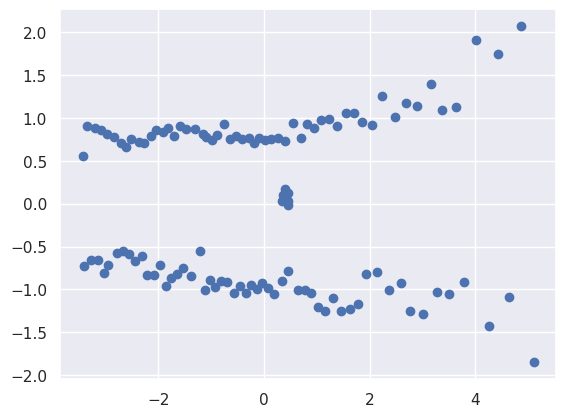

In [5]:
pca = PCA(n_components=2)
embs = pca.fit_transform(model.emb[0].detach().cpu().numpy())
print("PCA:", pca.explained_variance_ratio_, "\n")
plt.plot(embs[:, 0], embs[:, 1], "o")

Now, I'm going to do a simple analysis to see how the model predictions changes as I keep Z fixed and vary N.

In [6]:
task_names = list(data.output_map.keys())   # get a list of names of tasks (e.g. binding_semf)
magic_numbers = [2, 8, 20, 28, 50, 82, 126][1::]
# keep Z fixed and change N see how BE changes.
task_name = "binding_semf"
task_idx = task_names.index(task_name)
protons = 82
max_neutrons = 130
inputs = torch.full((max_neutrons - 9, 3), protons) # 9 is the minimum number of neutrons
inputs[:, 1] = torch.arange(9, max_neutrons) # change the number of neutrons
inputs[:, 2] = task_idx # change the task index
preds = model(inputs)
preds = preds[:, task_idx].cpu().detach() # get the predictions for the task

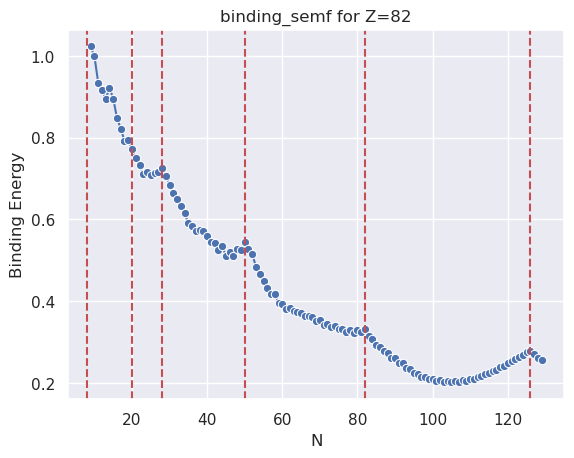

In [7]:
sns.lineplot(x=inputs[:, 1], y=preds, marker='o')
for magic_number in magic_numbers:
    plt.axvline(magic_number, color='r', linestyle='--')
plt.xlabel("N")
plt.ylabel("Binding Energy")
plt.title(f"{task_name} for Z={protons}")
plt.savefig(f"plots/Z_{protons}_{task_name}.pdf", bbox_inches='tight', pad_inches=0)

Now, let's take a look at how the model predictions compare to the data.

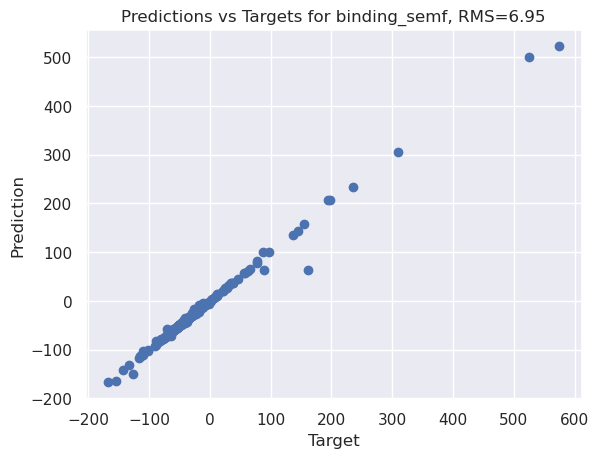

RMS: 6.95


In [38]:
def get_predictions_targets_for_task(task_name, train=True):
    # the data has an admittedly weird structure
    # data.X is a tensor of shape (N, 3) where N is the number of nuclei
    # TIMES the number of tasks. The first column is the number of protons,
    # the second column is the number of neutrons, and the third column is
    # the task index. 
    mask = data.train_mask if train else data.val_mask
    task_idx = task_names.index(task_name)
    X_train = data.X[mask]
    scatter = X_train[:, 2].cpu().numpy() == task_idx # get only rows relevant to task

    # get the targets and predictions for the task
    # first, we need to undo the preprocessing
    # data.regresion_transformer is a sklearn transformer that does the preprocessing
    # we can use its inverse_transform method to undo the preprocessing
    # it expects a numpy array, of shape (samples, features) where features is the number
    # of tasks we have.
    targets = data.y.view(-1, 10).cpu().numpy()
    targets = data.regression_transformer.inverse_transform(targets)
    targets = targets.flatten()[mask.cpu().numpy()]
    targets = targets[scatter]

    # Predictions on the other hand are shape (samples, tasks)
    # each row has one correct prediction, and the rest are not useful
    # this is not optimal but not worth optimizing for now
    preds = model(data.X[mask])
    preds = preds.cpu().detach().numpy()
    preds = data.regression_transformer.inverse_transform(preds)[scatter, task_idx]
    return preds, targets


def plot_predictions(task_name, train=True):
    preds, targets = get_predictions_targets_for_task(task_name, train)

    non_nan_targets = ~np.isnan(targets)
    targets = targets[non_nan_targets]
    preds = preds[non_nan_targets]

    rms = np.sqrt(np.mean((preds - targets)**2))

    plt.plot(targets, preds, "o")
    plt.xlabel("Target")
    plt.ylabel("Prediction")
    plt.title(f"Predictions vs Targets for {task_name}, RMS={rms:.2f}")
    plt.show()
    print(f"RMS: {rms:.2f}")
    
plot_predictions("binding_semf", train=False)

## Reverting Back to Binding Energies
Let's convert the model predictions to actual binding energies in keV. The model we trained predicts differences from the semi-empirical mass formula (SEMF) binding energies. So, we need to add the SEMF binding energies back to the model predictions to get the actual binding energies.

In [34]:
from data import get_nuclear_data, get_targets, semi_empirical_mass_formula
import pandas as pd 


NZ = data.X[::len(data.output_map), :2].cpu().numpy()
y_orig = data.regression_transformer.inverse_transform(data.y.view(-1, len(data.output_map)).cpu().numpy())

df_data = np.concatenate([NZ, y_orig], axis=1)
df_data = pd.DataFrame(df_data, columns=["Z", "N"]+task_names)
df_data["binding"] = semi_empirical_mass_formula(df_data["Z"], df_data["N"]) + df_data["binding_semf"]
df_data.head()

,Z,N,binding_semf,n,qa,qbm,qbm_n,qec,radius,sn,sp,z,binding
0,9.0,9.0,-94.804138,9.000000,-4415.221191,-4444.505859,-23698.658203,1655.928345,NaN,9149.907227,5607.094727,9.0,7631.638295
1,9.0,10.0,-224.958405,10.000000,-4013.798828,-3239.498291,-14876.380859,-4820.303711,2.8976,10431.875977,7993.599609,9.0,7779.019195
2,9.0,11.0,-167.327927,11.000000,-8126.286133,7024.470703,-9840.835938,-3813.634766,NaN,6601.335938,10639.291992,9.0,7720.135103
3,9.0,12.0,-192.668701,12.000000,-10342.599609,5684.170410,-1076.991821,-8109.638672,NaN,8101.459961,11132.748047,9.0,7738.293393
4,9.0,13.0,-50.938557,13.000001,-12744.707031,10818.090820,453.832184,-6489.656738,NaN,5230.336914,12557.628906,9.0,7624.295398


Now that we have our targets back in the original units. Let's convert the predictions of the model.

In [ ]:
preds, targets = get_predictions_targets_for_task("binding_semf", train=True)
df_train = np.concatenate(NZ[data.train_mask.cpu().numpy()], preds, targets)